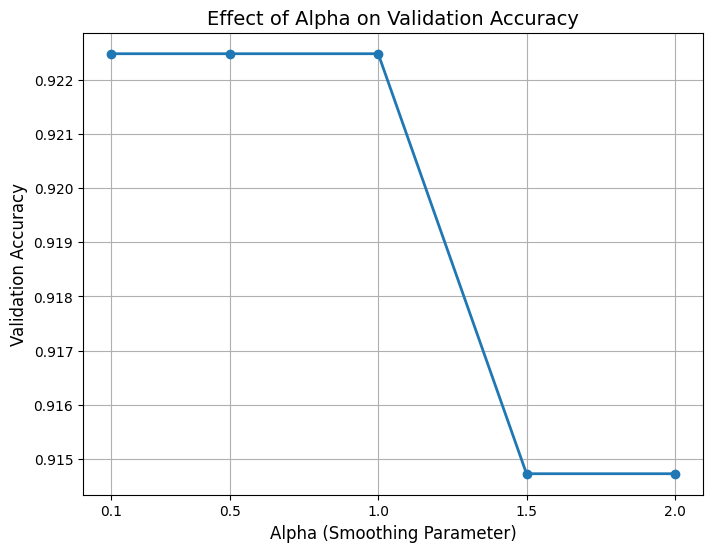

Best Alpha: 0.1, Best Validation Accuracy: 0.9224806201550387
Test Accuracy with Tuned Alpha: 0.933852140077821

Test Classification Report:
                     precision    recall  f1-score   support

          business       0.96      0.96      0.96        53
     entertainment       0.97      0.93      0.95        60
science-technology       0.95      0.80      0.86        44
            sports       0.98      1.00      0.99        56
             world       0.81      0.95      0.88        44

          accuracy                           0.93       257
         macro avg       0.93      0.93      0.93       257
      weighted avg       0.94      0.93      0.93       257



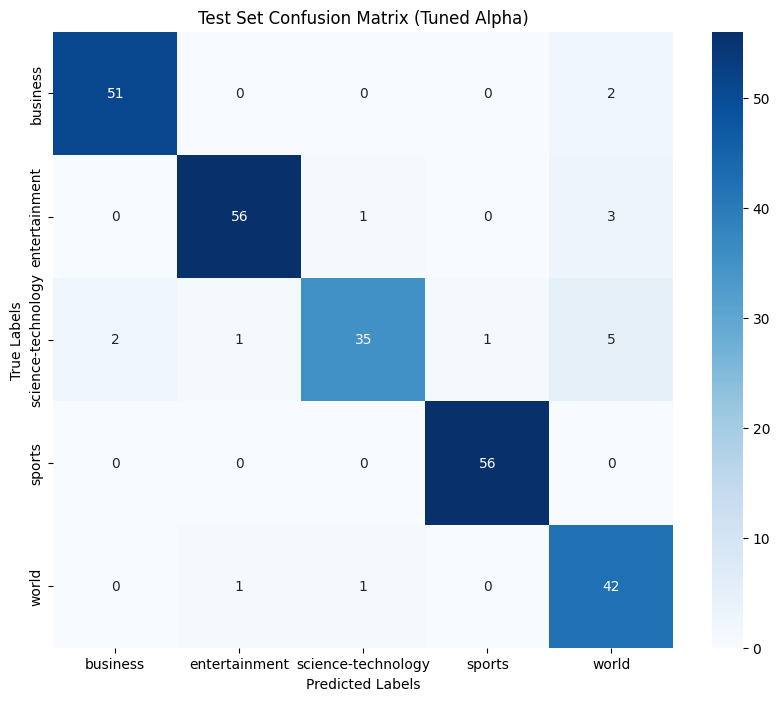

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

dataset = pd.read_csv('preprocessed_dataset.csv')
dataset = dataset.dropna(subset=['content'])  
dataset['content'] = dataset['content'].astype(str)  

X = dataset['content']
y = dataset['gold_label']

vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X).toarray()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_bow, y, test_size=0.2, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.125, stratify=y_train_full)



class MultinomialNB:
    def __init__(self,alpha=1.0):
        self.alpha=alpha
        self.priors = None
        self.feature_probs = None
        self.classes = None

    def fit(self, X, y):
        
        self.classes, class_counts = np.unique(y, return_counts=True)
        self.priors = class_counts / len(y)

        self.feature_probs = {}
        for c in self.classes:
            class_indices = np.where(y == c)[0]
            X_class = X[class_indices]
            word_counts = X_class.sum(axis=0) + self.alpha
            self.feature_probs[c] = word_counts / (word_counts.sum() + self.alpha * X.shape[1])

    def predict(self, X):
        log_probs = []
        for c in self.classes:  
            log_prior = np.log(self.priors[np.where(self.classes == c)][0])
            log_likelihood = np.multiply(X, np.log(self.feature_probs[c])).sum(axis=1)
            log_probs.append(log_prior + log_likelihood)

        log_probs = np.array(log_probs).T
        return self.classes[np.argmax(log_probs, axis=1)]

alpha_values = [0.1, 0.5, 1.0, 1.5, 2.0]
val_accuracies = [] 

best_alpha = None
best_val_accuracy = 0
results = []

for alpha in alpha_values:
    nb_model = MultinomialNB(alpha=alpha)
    nb_model.fit(X_train, y_train)

    y_val_pred = nb_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    val_accuracies.append(val_accuracy)

plt.figure(figsize=(8, 6))
plt.plot(alpha_values, val_accuracies, marker='o', linestyle='-', linewidth=2)
plt.title('Effect of Alpha on Validation Accuracy', fontsize=14)
plt.xlabel('Alpha (Smoothing Parameter)', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xticks(alpha_values)
plt.grid(True)
plt.show()

best_alpha = alpha_values[np.argmax(val_accuracies)]
print(f"Best Alpha: {best_alpha}, Best Validation Accuracy: {max(val_accuracies)}")

final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(X_train_full, y_train_full)

y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Test Accuracy with Tuned Alpha:", test_accuracy)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred, labels=final_model.classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=final_model.classes, yticklabels=final_model.classes)
plt.title("Test Set Confusion Matrix (Tuned Alpha)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
